In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import model
from sklearn import preprocessing

device = torch.device("cuda")
print(f'Selected device: {device}')

c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selected device: cuda


In [2]:
with open('../trainset_14-class.pickle', 'rb') as file:
    trainset = pickle.load(file)

spectrogram = torch.from_numpy(trainset['spectrogram'].astype(np.float32))
texture = trainset['texture']
le = preprocessing.LabelEncoder()
labels = torch.as_tensor(le.fit_transform(texture))

def Normalization(X):
    Xmin = X.min()
    Xmax = X.max()
    X_norm = (X - Xmin) / (Xmax - Xmin)
    X_norm = 2 * X_norm - 1
    return X_norm

spectrogram = Normalization(spectrogram)

train_dataset = torch.utils.data.TensorDataset(spectrogram, labels)
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 128,
    shuffle = True,
    num_workers = 0,
    )

In [4]:
le.inverse_transform(np.arange(14))

array(['G1RhombAluminumMesh', 'G1SquaredAluminumMesh',
       'G2GraniteTypeVeneziano', 'G2RoofTile', 'G3AluminumPlate',
       'G3CeramicPlate', 'G4Bamboo', 'G4LaminatedWood', 'G6Carpet',
       'G6Fiber', 'G8Cardboard', 'G8WallPaper', 'G9FloorCloth',
       'G9Kashimir'], dtype='<U22')

In [4]:
# encoder = model.ResNetEncoder(feat_dim=128)

# encoder_dict = torch.load('encoder_128d.pt', map_location=torch.device('cpu'))
# encoder_dict = {k: v for k, v in encoder_dict.items()}
# encoder.load_state_dict(encoder_dict)

generator = model.Generator(feat_dim=128)

generator_dict = torch.load('generator_128d.pt', map_location=torch.device('cpu'))
generator_dict = {k: v for k, v in generator_dict.items()}
generator.load_state_dict(generator_dict)

# encoder.eval() 
# encoder.to(device)
generator.eval() 
generator.to(device)

Generator(
  (resize_x): Linear(in_features=128, out_features=960, bias=True)
  (unflatten_x): Unflatten(dim=1, unflattened_size=(1, 12, 80))
  (conv_input): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (residual): Sequential(
    (0): _Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): _Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)

In [12]:
latent_dict = {'z': [], 'label': []}

for i, (img, label) in enumerate(train_dataloader):
    img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
    img = img.to(device)
    label = label.to(torch.float32).to(device)

    z = encoder(img)

    latent_dict['z'].extend(z.detach().cpu().numpy().tolist())
    latent_dict['label'].extend(label.detach().cpu().numpy().tolist())

In [13]:
file = open('latent_dict.pickle', 'wb')
pickle.dump(latent_dict, file)
file.close()

In [3]:
from sklearn.decomposition import PCA 
import joblib

with open('latent_dict.pickle', 'rb') as file:
    latent_dict = pickle.load(file)

# pca = PCA(n_components=2)	# 特征个数
# pca_z = pca.fit_transform(latent_dict['z'])
# print(pca_z.min(), pca_z.max())
# joblib.dump(pca, 'PCA_z20.m')


In [16]:
tsne = TSNE(n_components=2, init='pca')

X = np.array(latent_dict['z'])
print(X.shape)
X_tsne = tsne.fit_transform(X)

(24480, 128)


c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Text(0, 0.5, '')

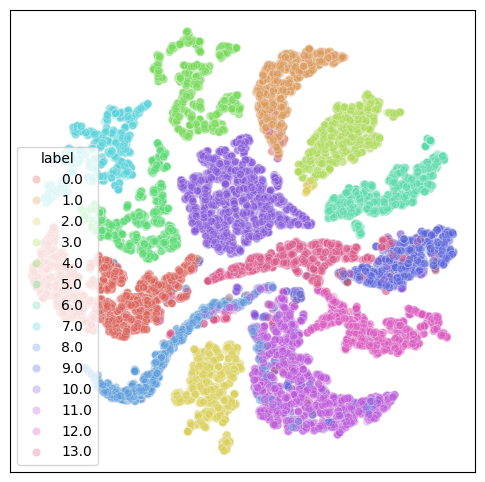

In [17]:
import seaborn as sns
import pandas as pd

plt_data = pd.DataFrame()

plt_data['tsne_x'] = X_tsne[:,0]
plt_data['tsne_y'] = X_tsne[:,1]
plt_data['label'] = latent_dict['label']

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="label",
    palette=sns.color_palette("hls", 14),
    data=plt_data,
    legend="full",
    alpha=0.3
)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

In [22]:
with open('../trainset_7-class.pickle', 'rb') as file:
    testset = pickle.load(file)

testset = torch.from_numpy(testset['spectrogram'].astype(np.float32))

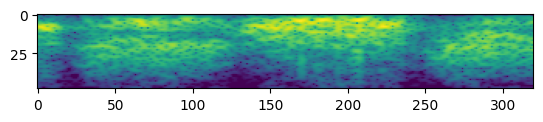

In [24]:
test_spec = spectrogram[7000]
plt.imshow(test_spec)

In [5]:
import librosa
import torchaudio
import sounddevice as sd
def spec2wav(spec):
    griffinlim = torchaudio.transforms.GriffinLim(n_fft=2048, n_iter=50, hop_length=int(2048 * 0.1), power=1.0)
    griffinlim = griffinlim.to(device)

    ex = np.full((1025 - spec.shape[0], spec.shape[1]), -80) #もとの音声の周波数上限を切っているので配列の大きさを合わせるために-80dbで埋めている
    spec = np.append(spec, ex, axis=0)

    spec = librosa.db_to_amplitude(spec)
    re_wav = griffinlim(torch.tensor(spec).to(device))

    return re_wav.cpu().detach().numpy()

In [11]:
def img_denormalize(img):
    # Min of original data: -80
    # Max of original data: 0
    origin_max = 0.
    origin_min = -80.
    img = (img + 1) / 2 # from [-1, 1] back to [0, 1]
    denormalized_img = img * (origin_max - origin_min) + origin_min
    return denormalized_img

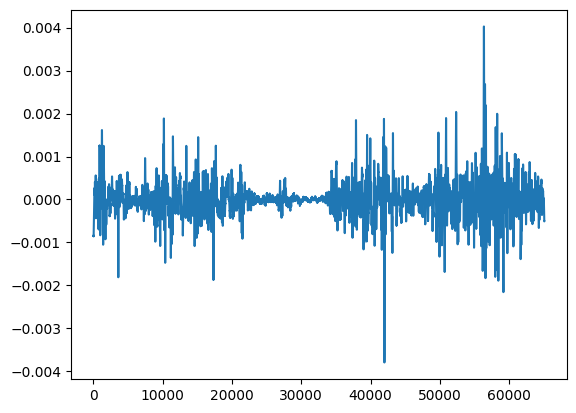

In [14]:
# re_spec = generator(encoder(torch.tensor(test_spec.unsqueeze(dim=0).to(device))))
# re_spec = generator(torch.tensor(np.random.uniform(low=-2.5, high=2.5, size=(128))).unsqueeze(dim=0).to(torch.float32).to(device))
# sss = encoder(torch.tensor(spectrogram[23000].unsqueeze(dim=0).to(device)))
# print(sss.min())
# print(sss.max())
# re_spec = generator(torch.tensor(np.random.uniform(low=-2.5, high=2.5, size=(128))).unsqueeze(dim=0).to(torch.float32).to(device))
# re_spec = generator(sss)
re_spec = generator(torch.tensor(latent_dict['z'][23000]).unsqueeze(dim=0).to(torch.float32).to(device))
re_spec = img_denormalize(re_spec)

wav = spec2wav(re_spec.cpu().detach().squeeze().numpy())
plt.plot(wav)
wav = wav * 100
wav = np.tile(wav, 10)
sd.play(wav, samplerate=44100)

# plt.imshow(re_spec.cpu().detach().squeeze().numpy(), cmap='gray')

# plt.axis('off')

In [30]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_image('Spectrogram', re_spec[0])

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'